In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeRegressor
from joblib import dump

# Load the dataset
file_path = 'profile_Dataset.csv'  # Replace with the path to your dataset
data = pd.read_csv(file_path)

# Preprocessing the data
# Handle missing values (e.g., fill with median for numerical columns)
data.fillna(data.median(numeric_only=True), inplace=True)

# Encode categorical variables (if any)
for column in data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])

# Normalize numerical features
scaler = MinMaxScaler()
numerical_columns = data.select_dtypes(include=np.number).columns.drop('fake')  # 'fake' is the target
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])


# Separate features (X) and target (y)
X = data.drop(columns=['fake']).to_numpy()  # Features
y = data['fake'].to_numpy()  # Target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


class KNNMODEL:
    def _init_(self):
        self.X_train = None
        self.y_train = None
        self.k = None  # Store k as a class attribute

    @staticmethod
    def euclidean_distance(x1, x2):
        differences = x1 - x2
        squared_differences = differences ** 2
        summed_squares = np.sum(squared_differences, axis=1)
        distance = np.sqrt(summed_squares)
        return distance

    def fit(self, X_train, y_train, k):
        """ Store the training data and k value """
        self.X_train = X_train
        self.y_train = y_train
        self.k = k  # Store k value

    def predict(self, X_test):
        """ Make predictions using the stored training data and k value """
        predictions = []
        for test_point in X_test:
            distances = self.euclidean_distance(self.X_train, test_point)
            sorted_indices = np.argsort(distances)
            nearest_neighbors = sorted_indices[:self.k]  # Use the stored k value
            neighbor_labels = self.y_train[nearest_neighbors]
            most_common_label = np.bincount(neighbor_labels).argmax()
            predictions.append(most_common_label)
        return np.array(predictions)

    def k_fold_cross_validation(self, X, y, k_folds, k_values):
        fold_size = len(X) // k_folds
        avg_accuracies = []
        fold_results = []
        avg_squared_errors = []

        for k_val in k_values:
            accuracies = []
            squared_errors = []
            for fold in range(k_folds):
                start_index = fold * fold_size
                end_index = (fold + 1) * fold_size
                X_test = X[start_index:end_index]
                y_test = y[start_index:end_index]
                X_train = np.concatenate([X[:start_index], X[end_index:]], axis=0)
                y_train = np.concatenate([y[:start_index], y[end_index:]], axis=0)

                # Fit the model on the training data and store k
                self.fit(X_train, y_train, k_val)

                y_pred = self.predict(X_test)
                accuracy = np.mean(y_pred == y_test)
                accuracies.append(accuracy)
                squared_error = np.sum((y_pred - y_test) ** 2)
                squared_errors.append(squared_error)

            avg_accuracies.append(np.mean(accuracies))
            avg_squared_errors.append(np.mean(squared_errors))
            fold_results.append(accuracies)

        overall_avg_accuracy = np.mean(avg_accuracies)
        overall_avg_squared_error = np.mean(avg_squared_errors)
        return avg_accuracies, fold_results, avg_squared_errors, overall_avg_accuracy, overall_avg_squared_error


# Initialize KNN model
knn = KNNMODEL()

# Define parameters
k_values = [1, 3, 5, 7, 9]
k_folds = 5

# Using k-fold cross-validation
avg_accuracies, fold_results, avg_squared_errors, overall_avg_accuracy_k_fold, overall_avg_squared_error_k_fold = knn.k_fold_cross_validation(X, y, k_folds, k_values)

# KNN on the split data (Train and Test)
knn_accuracies = []
knn_squared_errors = []
for k in k_values:
    # Fit the model on the entire dataset and store k
    knn.fit(X, y, k)
    y_pred = knn.predict(X)  # Using the entire dataset to predict on itself
    accuracy = np.mean(y_pred == y)
    knn_accuracies.append(accuracy)
    squared_error = np.sum((y_pred - y) ** 2)
    knn_squared_errors.append(squared_error)

# Saving the trained KNN model

dump(knn,'KNN.joblib')


# Print results
results = {
    "k_values": k_values,
    "k_fold_squared_errors": avg_squared_errors,
    "knn_squared_errors": knn_squared_errors,
    "k_fold_accuracies": avg_accuracies,
    "knn_accuracies": knn_accuracies,
    "overall_avg_accuracy_k_fold": overall_avg_accuracy_k_fold,
    "overall_avg_squared_error_k_fold": overall_avg_squared_error_k_fold
}

print("------------------------>Results for KNN Classifier<-------------------------------------")
print("K Values are:", k_values)
print("Overall KNN Squared Errors for each k:", knn_squared_errors)
print("Overall KNN Accuracies for each k:", knn_accuracies)
print("\n\n-------------------->Results for K-FOLD CROSS VALIDATION<---------------------------")
print("K-Fold Squared Errors for each k:", avg_squared_errors)
print("Overall Average Squared Error for k-Fold Cross Validation:", overall_avg_squared_error_k_fold)
print("K-Fold Accuracies for each k:", avg_accuracies)
print("Overall Average Accuracy for k-Fold Cross Validation:", overall_avg_accuracy_k_fold)




------------------------>Results for KNN Classifier<-------------------------------------
K Values are: [1, 3, 5, 7, 9]
Overall KNN Squared Errors for each k: [np.int64(0), np.int64(46), np.int64(55), np.int64(61), np.int64(63)]
Overall KNN Accuracies for each k: [np.float64(1.0), np.float64(0.9339080459770115), np.float64(0.9209770114942529), np.float64(0.9123563218390804), np.float64(0.9094827586206896)]


-------------------->Results for K-FOLD CROSS VALIDATION<---------------------------
K-Fold Squared Errors for each k: [np.float64(23.0), np.float64(22.0), np.float64(24.0), np.float64(23.6), np.float64(21.0)]
Overall Average Squared Error for k-Fold Cross Validation: 22.72
K-Fold Accuracies for each k: [np.float64(0.8345323741007193), np.float64(0.8417266187050358), np.float64(0.8273381294964028), np.float64(0.8302158273381295), np.float64(0.8489208633093526)]
Overall Average Accuracy for k-Fold Cross Validation: 0.836546762589928


Decision Tree Accuracy: 0.90
Random Forest Accuracy: 0.91
Random Forest model saved as 'random_forest_model.joblib'


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6256\430450084.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(models), y=list(accuracies), palette="viridis")  # Explicitly convert to list


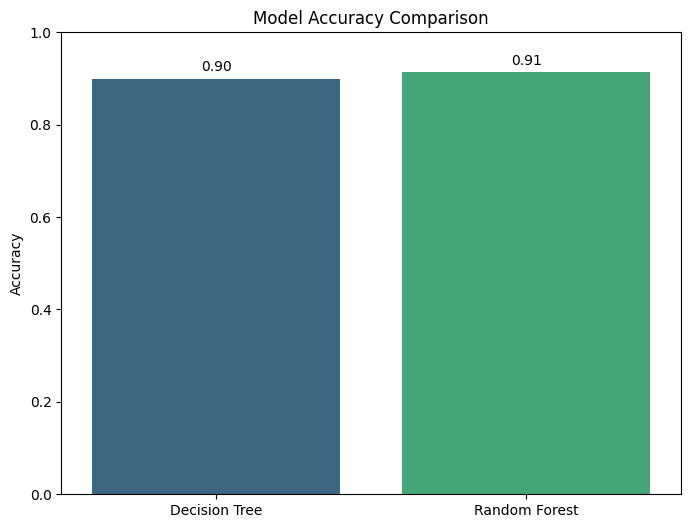

In [3]:
def gini_impurity(y):
    """Calculate Gini Impurity for a set of labels."""
    unique, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities**2)

def split_dataset(X, y, feature_idx, threshold):
    """Split the dataset based on a feature and its threshold."""
    left_mask = X[:, feature_idx] <= threshold
    right_mask = ~left_mask
    return X[left_mask], X[right_mask], y[left_mask], y[right_mask]


def best_split(X, y):
    """Find the best feature and threshold to split the dataset."""
    n_samples, n_features = X.shape
    best_feature, best_threshold, best_gini = None, None, float('inf')

    for feature_idx in range(n_features):
        thresholds = np.unique(X[:, feature_idx])
        for threshold in thresholds:
            _, _, y_left, y_right = split_dataset(X, y, feature_idx, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue

            gini = (len(y_left) / n_samples) * gini_impurity(y_left) + \
                   (len(y_right) / n_samples) * gini_impurity(y_right)

            if gini < best_gini:
                best_feature, best_threshold, best_gini = feature_idx, threshold, gini

    return best_feature, best_threshold

# Decision Tree Class
class DecisionTree:
    """A simple implementation of a decision tree."""
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y, depth=0):
        """Build the decision tree recursively."""
        if len(np.unique(y)) == 1 or (self.max_depth is not None and depth >= self.max_depth):
            # Handle empty subsets or exceeding depth
            if len(y) == 0:
                return 0  # Return a default value (e.g., 0) if the subset is empty
            else:
                # Ensure y contains only non-negative values
                y_non_negative = np.where(y < 0, 0, y)
                return np.bincount(y_non_negative).argmax()

        feature_idx, threshold = best_split(X, y)
        if feature_idx is None:
            return np.bincount(y).argmax()

        X_left, X_right, y_left, y_right = split_dataset(X, y, feature_idx, threshold)
        node = {"feature": feature_idx, "threshold": threshold}
        node["left"] = self.fit(X_left, y_left, depth + 1)
        node["right"] = self.fit(X_right, y_right, depth + 1)
        return node

    def predict_sample(self, node, x):
        """Predict the class for a single sample."""
        if isinstance(node, dict):
            if x[node["feature"]] <= node["threshold"]:
                return self.predict_sample(node["left"], x)
            else:
                return self.predict_sample(node["right"], x)
        return node

    def predict(self, X):
        """Predict classes for multiple samples."""
        return np.array([self.predict_sample(self.tree, x) for x in X])

# Random Forest Class
class RandomForest:
    """A simple implementation of a Random Forest classifier."""
    def __init__(self, n_trees=10, max_depth=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def bootstrap_sample(self, X, y):
        """Generate a bootstrap sample of the dataset."""
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        """Fit multiple decision trees on bootstrap samples."""
        self.trees = []
        for _ in range(self.n_trees):
            X_sample, y_sample = self.bootstrap_sample(X, y)
            tree = DecisionTree(max_depth=self.max_depth)
            tree.tree = tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Get predictions from individual trees
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])

        # Ensure tree_predictions are integers
        tree_predictions = tree_predictions.astype(int)

        # Ensure predictions are non-negative
        tree_predictions[tree_predictions < 0] = 0  # Or handle negative values appropriately

        if tree_predictions.size == 0:
          raise ValueError("No predictions available the trees.")

        # Apply bincount and argmax
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_predictions)



# Train the Decision Tree model
tree = DecisionTree(max_depth=5)  # You can choose a different max_depth if needed
tree.tree = tree.fit(X_train, y_train)

# Make predictions
tree_predictions = tree.predict(X_test)

# Evaluate accuracy
tree_accuracy = np.mean(tree_predictions == y_test)
print(f"Decision Tree Accuracy: {tree_accuracy:.2f}")

# Save the trained random forest model

# Train the Random Forest model
forest = RandomForest(n_trees=10, max_depth=5)
forest.fit(X_train, y_train)

# Make predictions
forest_predictions = forest.predict(X_test)

# Evaluate accuracy
accuracy = np.mean(forest_predictions == y_test)
print(f"Random Forest Accuracy: {accuracy:.2f}")


# Save the trained random forest model
dump(forest, 'random_forest_model.joblib')
print("Random Forest model saved as 'random_forest_model.joblib'")


# Accuracy comparison bar chart
models = ['Decision Tree', 'Random Forest']
accuracies = [tree_accuracy, accuracy]

plt.figure(figsize=(8, 6))
sns.barplot(x=list(models), y=list(accuracies), palette="viridis")  # Explicitly convert to list
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', va='bottom')
plt.show()


Manual Gradient Boosting Accuracy: 0.93
Decision Tree Regressor Accuracy: 0.89


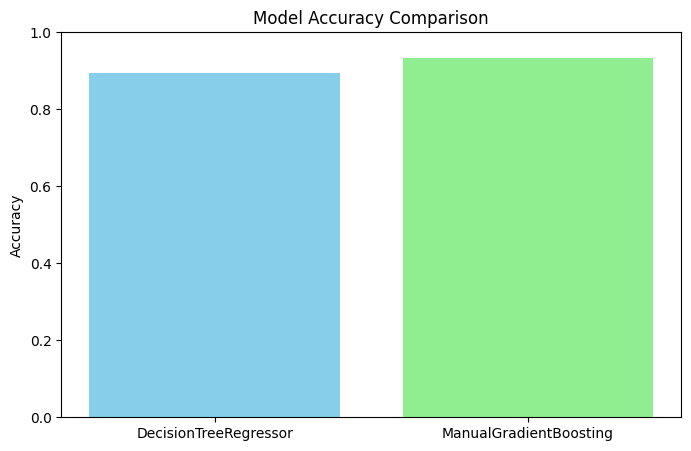

In [4]:
# Manual Gradient Boosting Implementation
class ManualGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):  # Fixed '__init__' typo
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.initial_mean = 0

    def fit(self, X, y):
        # Convert binary labels to {-1, 1}
        y = np.where(y == 0, -1, 1)

        # Initial prediction: mean of target labels
        self.initial_mean = np.mean(y)

        predictions = np.full(y.shape, self.initial_mean)

        for _ in range(self.n_estimators):
            # Compute residuals (pseudo-residuals)
            residuals = y - predictions

            # Train a weak learner (decision tree regressor) on the residuals
            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(X, residuals)
            self.models.append(model)

            # Update predictions
            predictions += self.learning_rate * model.predict(X)

    def predict(self, X):
        # Start with the initial mean for all samples
        predictions = np.full(X.shape[0], self.initial_mean)

        # Add contributions from weak learners
        for model in self.models:
            predictions += self.learning_rate * model.predict(X)

        # Convert to binary labels
        return np.where(predictions >= 0, 1, 0)

# Train and evaluate Manual Gradient Boosting
manual_gb = ManualGradientBoosting(n_estimators=50, learning_rate=0.1, max_depth=3)
manual_gb.fit(X_train, y_train)
manual_gb_predictions = manual_gb.predict(X_test)
manual_gb_accuracy = accuracy_score(y_test, manual_gb_predictions)

# Train and evaluate DecisionTreeRegressor
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(X_train, y_train)
decision_tree_predictions = decision_tree.predict(X_test)
decision_tree_accuracy = accuracy_score(y_test, np.round(decision_tree_predictions))  # Round predictions for classification

# Save the trained random forest model
dump(decision_tree, 'decision_model.joblib')

# Print accuracies
print(f"Manual Gradient Boosting Accuracy: {manual_gb_accuracy:.2f}")
print(f"Decision Tree Regressor Accuracy: {decision_tree_accuracy:.2f}")

# Plotting the accuracies
models = ['DecisionTreeRegressor', 'ManualGradientBoosting']
accuracies = [decision_tree_accuracy, manual_gb_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

Accuracy on test set: 0.90


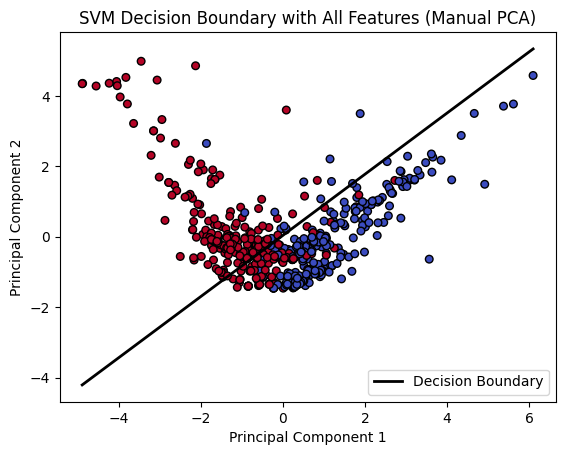

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Simple SVM Class Implementation
class SimpleSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (
                        2 * self.lambda_param * self.w - np.dot(x_i, y[idx])
                    )
                    self.b -= self.lr * y[idx]

    def predict(self, X):
        return np.sign(np.dot(X, self.w) - self.b)


# Function to normalize the dataset
def normalize_data(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)


# Function to compute PCA manually
def pca(X, n_components=2):
    # Step 1: Compute the covariance matrix
    covariance_matrix = np.cov(X.T)

    # Step 2: Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 3: Sort eigenvectors by descending eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_eigenvectors = eigenvectors[:, sorted_indices[:n_components]]

    # Step 4: Project data onto the top eigenvectors
    reduced_data = np.dot(X, top_eigenvectors)

    return reduced_data


# Function to split the dataset
def train_test_split(X, y, test_size=0.2):
    # Shuffle the dataset
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # Calculate the split index
    split_index = int((1 - test_size) * X.shape[0])

    # Split the data
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    return X_train, X_test, y_train, y_test


# Function to calculate accuracy
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


# Function to plot the decision boundary in 2D
def plot_decision_boundary_2d(X, y, svm, reduced_X):
    plt.scatter(
        reduced_X[:, 0], reduced_X[:, 1], c=y, cmap="coolwarm", s=30, edgecolors="k"
    )

    # Decision boundary in reduced space
    x0 = np.linspace(reduced_X[:, 0].min(), reduced_X[:, 0].max(), 100)
    x1 = (
        -(svm.w[0] * x0 + svm.b) / svm.w[1]
    )  # Project the high-dimensional weights onto 2D space
    plt.plot(x0, x1, color="black", linewidth=2, label="Decision Boundary")

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.title("SVM Decision Boundary with All Features (Manual PCA)")
    plt.show()

    # Load the dataset
    # Replace 'profile_Dataset.csv' with the actual file path
data = pd.read_csv("profile_Dataset.csv")

# Features and target selection
X = data.drop(columns=["fake"]).values  # All attributes except the target
y = data["fake"].values  # Target variable

# Encode the target variable (if not already binary: e.g., 0/1)
y = np.where(y == 1, 1, -1)

# Normalize the data
X = normalize_data(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train the SVM
svm = SimpleSVM()
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Calculate and print accuracy
acc = accuracy(y_test, y_pred)
print(f"Accuracy on test set: {acc:.2f}")

# Reduce dimensions for plotting using manual PCA
X_reduced = pca(X_train, n_components=2)

# Plot the decision boundary in 2D
plot_decision_boundary_2d(X_train, y_train, svm, X_reduced)


In [6]:
 while True:
     print("Please enter the values for the following features:")
     # Get individual inputs for each feature (13 features, including 'follows')
     profile_pic = float(input("Profile Picture (1 if present, 0 if absent): "))
     username_length = float(input("Username Length (number of characters): "))
     username_nums = float(input("Numerical Count in Username: "))
     fullname_length = float(input("Full Name Length (number of characters): "))
     fullname_words = float(input("Number of Words in Full Name: "))
     name_equals_username = float(input("Name equals Username (1 if yes, 0 if no): "))
     description_length = float(input("Description Length (number of characters): "))
     external_url = float(input("External URL (1 if present, 0 if absent): "))
     private = float(input("Private Account (1 if private, 0 if public): "))
     num_posts = float(input("Number of Posts: "))
     num_followers = float(input("Number of Followers: "))
     num_follows = float(input("Number of Follows: "))

     # Transformed features for the model
     second_feature = username_nums / username_length if username_length != 0 else 0  # Avoid division by zero
     fourth_feature = username_nums / fullname_length if fullname_length != 0 else 0  # Avoid division by zero

     # Prepare the user data as input for the model (including transformed features)
     user_data = [
         profile_pic,              # 1st feature
         second_feature,           # 2nd feature (nums/length of username)
         fullname_length,          # 3rd feature (original full name length)
         fourth_feature,           # 4th feature (nums/length of full name)
         name_equals_username,     # 5th feature
         description_length,       # 6th feature
         external_url,             # 7th feature
         private,                  # 8th feature
         num_posts,                # 9th feature
         num_followers,            # 10th feature
         num_follows               # 11th fe11ature
     ]

     # Display predictions for each model
     user_data = np.array(user_data).reshape(1, -1)

 #Make predictions for each model
     print("\n--- Predictions ---")


     model1=forest
     prediction = model1.predict(user_data)  # Ensure the shape is (1, n_features)
     print(f"{model1.__class__.__name__}: {'Fake' if prediction[0] else 'Real'} Account")


     model2=svm
     prediction = model2.predict(user_data)  # Ensure the shape is (1, n_features)
     print(f"{model2.__class__.__name__}: {'Fake' if prediction[0] else 'Real'} Account")


     model3=decision_tree
     prediction = model3.predict(user_data)  # Ensure the shape is (1, n_features)
     print(f"{model3.__class__.__name__}: {'Fake' if prediction[0] else 'Real'} Account")

     model4=knn
     prediction = model4.predict(user_data)  # Ensure the shape is (1, n_features)
     print(f"{model4.__class__.__name__}: {'Fake' if prediction[0] else 'Real'} Account")

     # Ask if the user wants to continue or stop
     continue_input = input("\nDo you want to enter new data? (y/n): ").lower()
     if continue_input != 'y':
         break
